In [1]:
!python3 train.py --conf_file conf_files/train_virtual.yaml

Reading the configuration from YALM file...
Loading dataset...
Loading model...
Preparation to train the model...
Training...

  2%|9                                        | 27/1215 [00:28<22:47,  1.15s/it]^C


In [1]:
from utils.load_dataset import *
from utils.custom_utils import *

In [2]:
import requests

url = 'https://pytraining-bot.herokuapp.com/notify'
myobj = {'message': 'DATTI UNA SVEGLIA',
        'chat_id': '425308083'}

In [3]:
train_df = load_training(target_txt)
test_df = load_testing(test_txt)
train, valid = split_train_valid(train_df)
weights = make_weights(train)

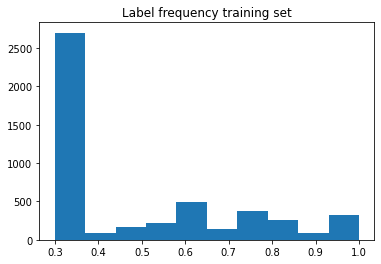

In [4]:
plt.title("Label frequency training set")
plt.hist(weights)
plt.show()

In [5]:
train_dataset = FallenPeople(train, DATASET, FallenPeople.train_transform())
valid_dataset = FallenPeople(valid, DATASET, FallenPeople.valid_test_transform())
test_dataset = FallenPeople(test_df, TESTING, FallenPeople.valid_test_transform())

Some images used during training...


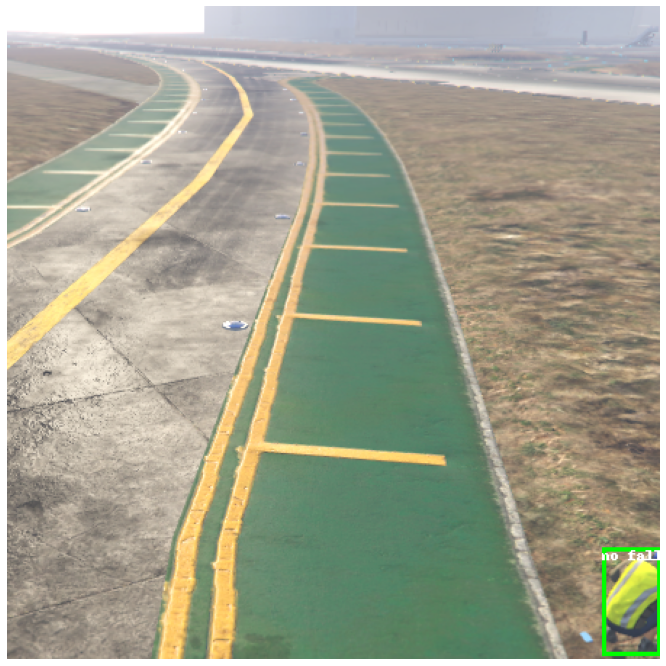

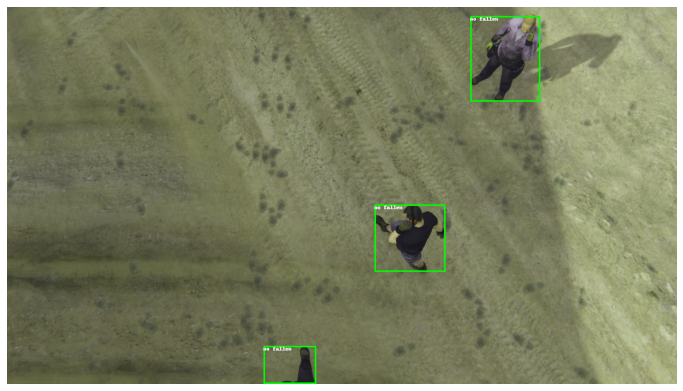

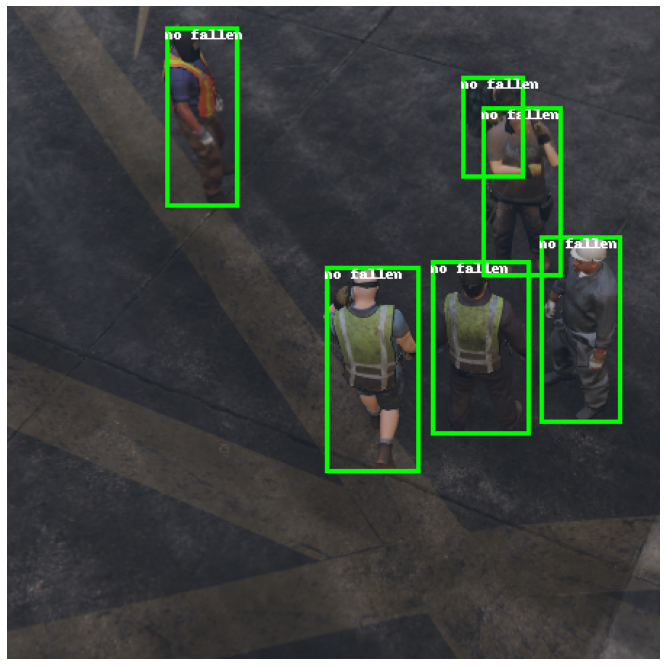

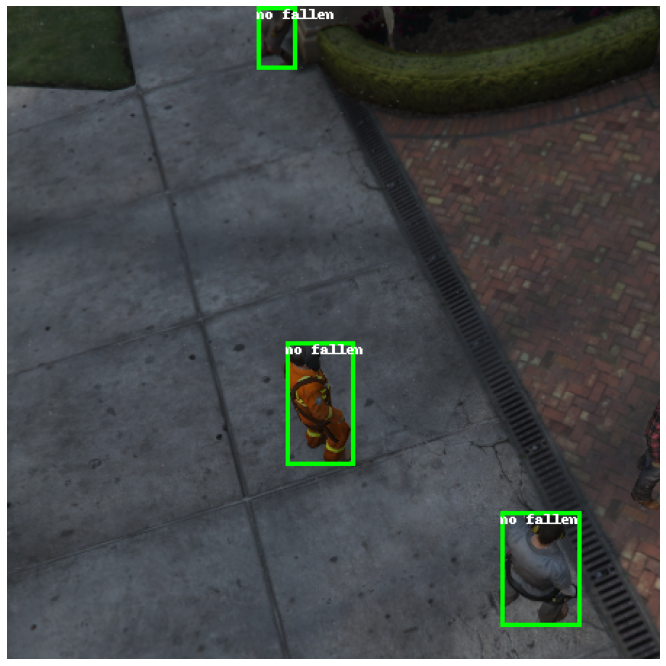

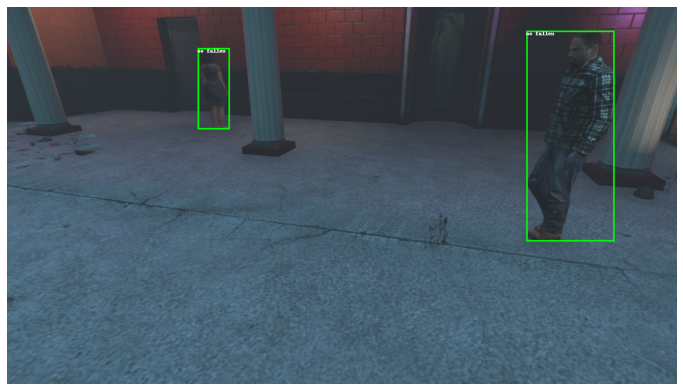

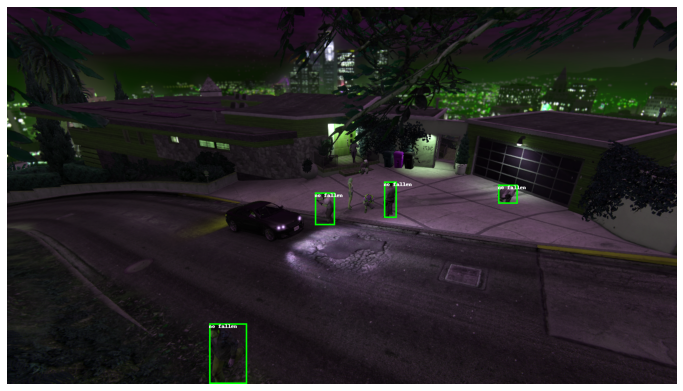

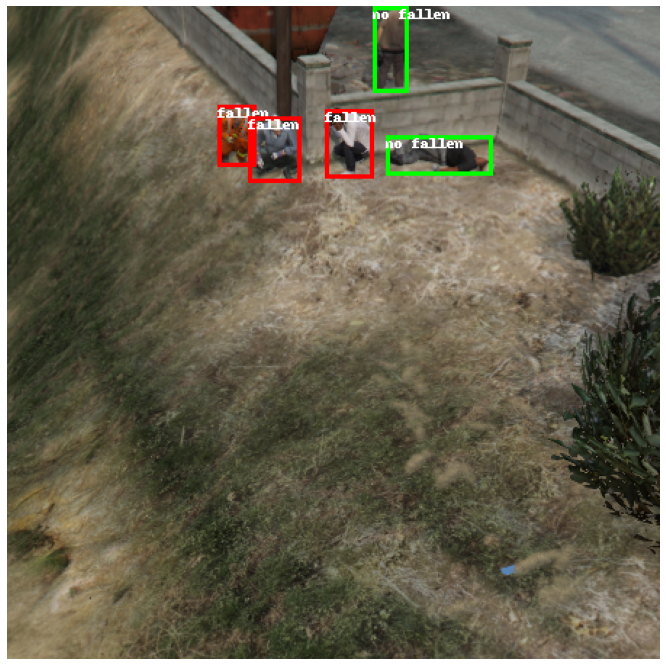

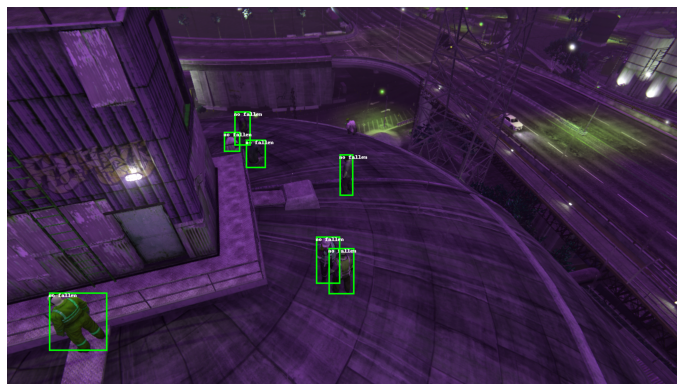

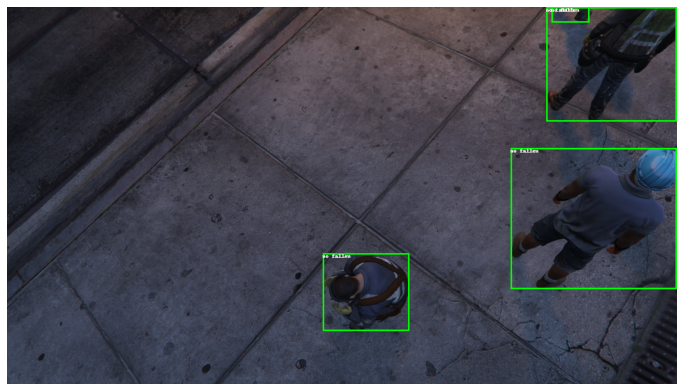

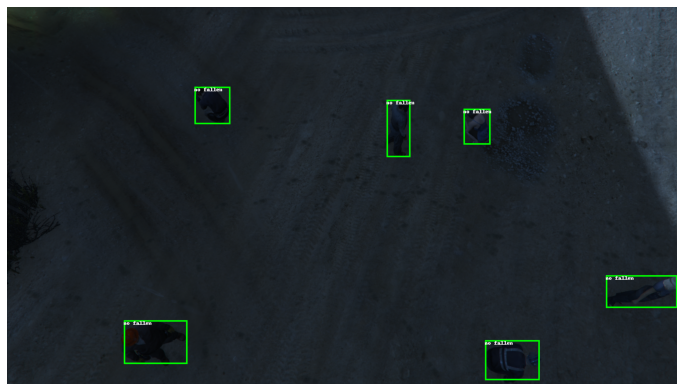

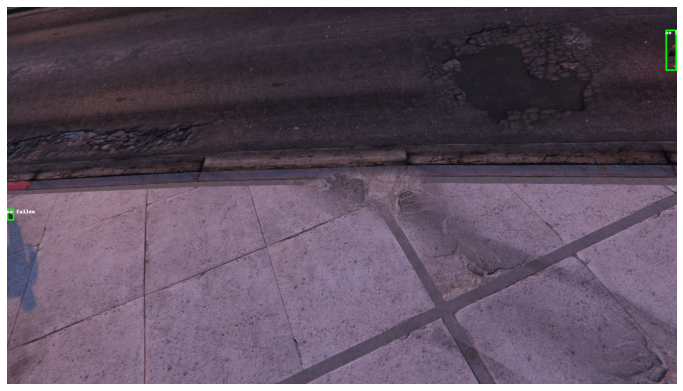

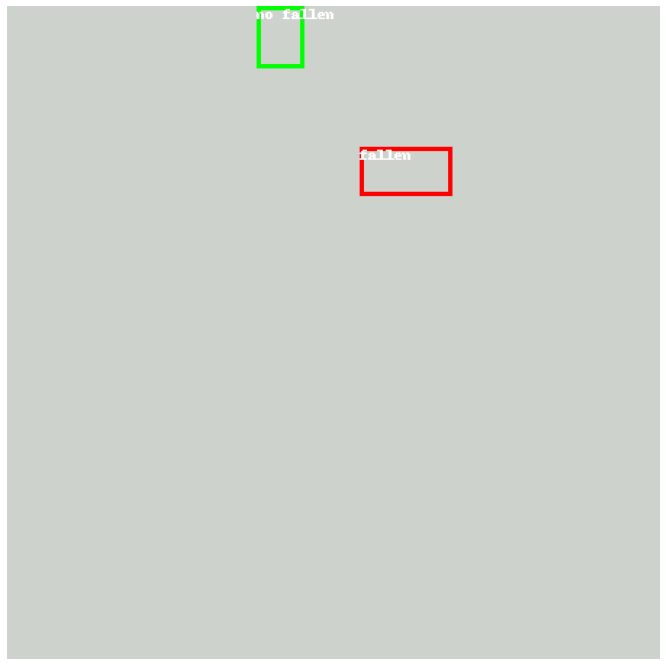

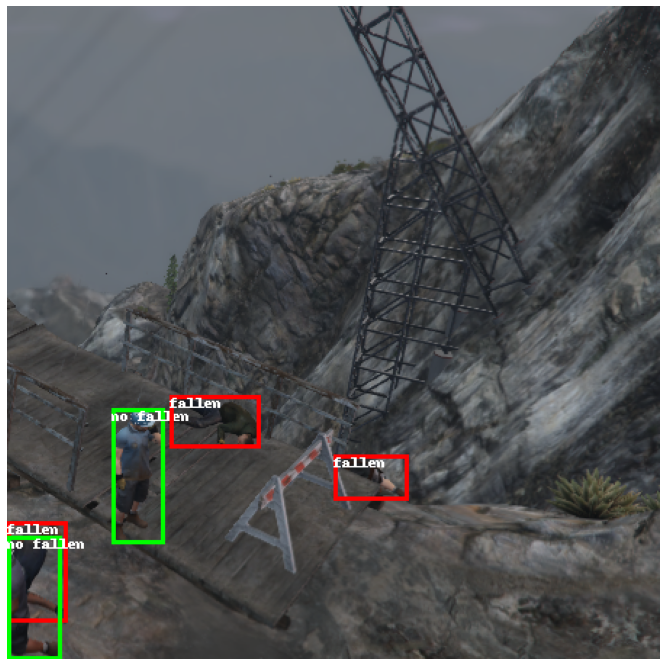

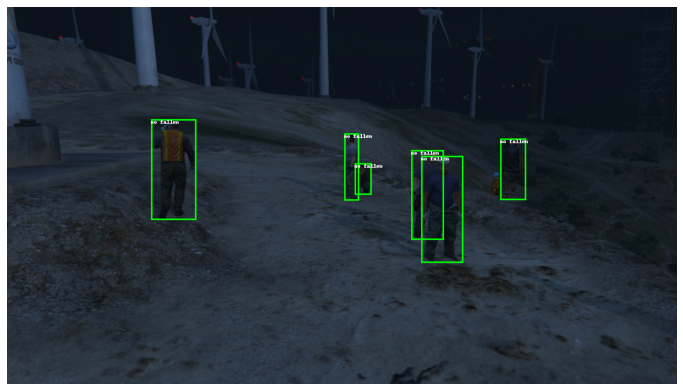

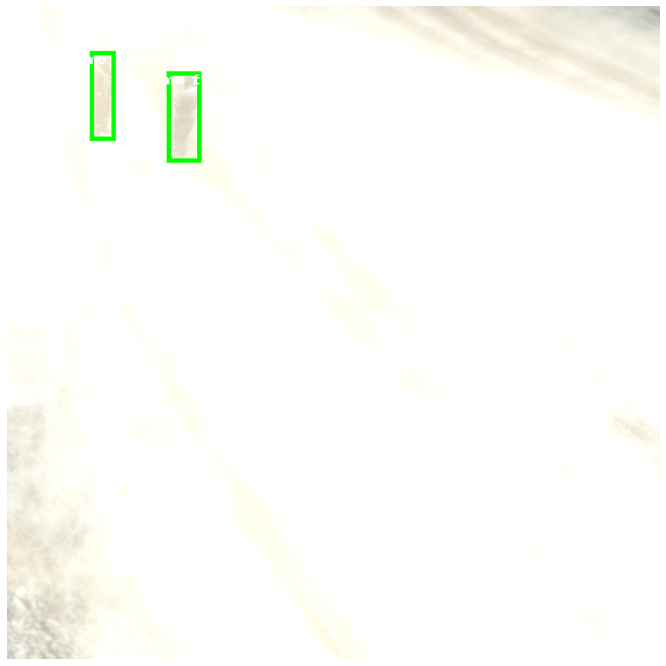

In [6]:
print("Some images used during training...")
random_list_fp = [random.randint(0,len(train_dataset)-1) for i in range(15)]

visualize_from_tensor_and_bb(train_dataset, random_list_fp)    

In [6]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [7]:
print(model.roi_heads.box_predictor)

num_classes = 3 # fall or no fall or not(background)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained model's head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

print(model.roi_heads.box_predictor)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)
FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=3, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=12, bias=True)
)


In [8]:
def collate_fn(batch):
  return tuple(zip(*batch))

sampler = torch.utils.data.WeightedRandomSampler(torch.DoubleTensor(weights), int(len(weights)))

train_data_loader = DataLoader(
  train_dataset,
  batch_size=4,
  #shuffle=False,
  collate_fn=collate_fn,
  sampler = sampler
)

valid_data_loader = DataLoader(
  valid_dataset,
  batch_size=4,
  shuffle=False,
  collate_fn=collate_fn
)

test_data_loader = DataLoader(
  test_dataset,
  batch_size=4,
  shuffle=False,
  collate_fn=collate_fn
)

In [9]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#***************
# move model to the right device
model.to(device)

# create an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# create a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

# train it for 10 epochs
num_epochs = 10

In [10]:
log_txt = filename("txt","trainlogs/log_file_")

In [11]:
itr = 1

total_train_loss = []
total_valid_loss = []

losses_value = 0.0

f_log = open(log_txt, "w")
for epoch in range(num_epochs):

  start_time = time.time()

  # train ------------------------------
  running_corrects = 0

  model.train()
  train_loss = []
  pbar = tqdm(train_data_loader, desc='let\'s train')
    
  for images, targets in pbar:    

    images = list(image.to(device) for image in images)

    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    losses_value = losses.item()
    train_loss.append(losses_value)   

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    f_log.write(f"Epoch: {epoch+1}, Batch: {itr}, Loss: {losses_value}\n")
    pbar.set_description(f"Epoch: {epoch+1}, Batch: {itr}, Loss: {losses_value}")
    itr += 1
    
  epoch_train_loss = np.mean(train_loss)
  total_train_loss.append(epoch_train_loss)

  # update the learning rate
  if lr_scheduler is not None:
    lr_scheduler.step()
    
  # valid -------------------------------------

  with torch.no_grad():
    valid_loss = []
    
    for images, targets in valid_data_loader:
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
      loss_dict = model(images, targets)
      losses = sum(loss for loss in loss_dict.values())
      loss_value = losses.item()
      valid_loss.append(loss_value)
    
  epoch_valid_loss = np.mean(valid_loss)
  total_valid_loss.append(epoch_valid_loss)  

  # print losses ------------------------------
  f_log.write("\nVALIDATION PHASE... ")
  print("\nVALIDATION PHASE... ")
  f_log.write(f"Epoch Completed: {epoch+1}/{num_epochs}, Time: {time.time()-start_time}, "
        f"Train Loss: {epoch_train_loss}, Valid Loss: {epoch_valid_loss}\n")  
  print(f"Epoch Completed: {epoch+1}/{num_epochs}, Time: {time.time()-start_time}, "
        f"Train Loss: {epoch_train_loss}, Valid Loss: {epoch_valid_loss}")

  #new valid
  sys.stdout = f_log
  evaluate(model, valid_data_loader, device=device)
  sys.stdout = original_stdout

  #testing --------------------------------------
  f_log.write("\nTESTING PHASE: ")  
  print("\nTESTING PHASE... ")
  sys.stdout = f_log
  evaluate(model, test_data_loader, device=device)
  sys.stdout = original_stdout
f_log.close()
x = requests.post(url, data = myobj)

let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


VALIDATION PHASE... 
Epoch Completed: 1/10, Time: 1292.8094379901886, Train Loss: 0.32186054403399245, Valid Loss: 0.4795236506646401

TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


VALIDATION PHASE... 
Epoch Completed: 2/10, Time: 1289.677094221115, Train Loss: 0.27479967109767006, Valid Loss: 0.4306158752082602

TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


VALIDATION PHASE... 
Epoch Completed: 3/10, Time: 1295.5426516532898, Train Loss: 0.26056758915629896, Valid Loss: 0.4352981878542586

TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


VALIDATION PHASE... 
Epoch Completed: 4/10, Time: 1283.192073583603, Train Loss: 0.2523271026097453, Valid Loss: 0.4248642604062824

TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


VALIDATION PHASE... 
Epoch Completed: 5/10, Time: 1297.0051128864288, Train Loss: 0.24865990878071315, Valid Loss: 0.4305265884062177

TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


VALIDATION PHASE... 
Epoch Completed: 6/10, Time: 1274.4053325653076, Train Loss: 0.23952397179211118, Valid Loss: 0.38633261072008235

TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


VALIDATION PHASE... 
Epoch Completed: 7/10, Time: 1552.8150732517242, Train Loss: 0.2432574223956944, Valid Loss: 0.43376999252818915

TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


VALIDATION PHASE... 
Epoch Completed: 8/10, Time: 1672.8946251869202, Train Loss: 0.23174833278535814, Valid Loss: 0.3846856958575939

TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


VALIDATION PHASE... 
Epoch Completed: 9/10, Time: 1770.9190964698792, Train Loss: 0.2329872023145603, Valid Loss: 0.40063162478863407

TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


VALIDATION PHASE... 
Epoch Completed: 10/10, Time: 1273.1886048316956, Train Loss: 0.23182298705411056, Valid Loss: 0.3998441848364708

TESTING PHASE... 


In [13]:
!nvidia-smi

Wed Dec  1 17:25:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    On   | 00000000:03:00.0 Off |                  N/A |
| 28%   33C    P8    10W / 180W |   1723MiB /  8117MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    On   | 00000000:04:00.0 Off |                  N/A |
| 27%   31C    P8     7W / 180W |     12MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

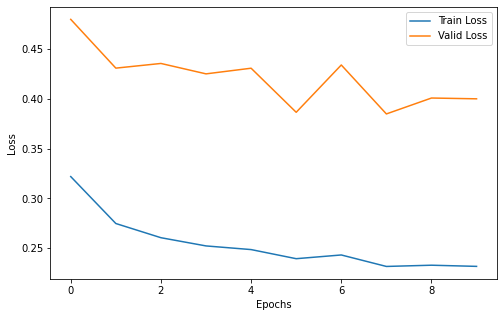

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(total_train_loss, label="Train Loss")
plt.plot(total_valid_loss, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(filename("png","snapshots/plots/train_valid_loss_"))
plt.show()

In [13]:
torch.save(model.state_dict(), filename("pth","models/fasterrcnn_resnet50_fallen_people_v1_"))